<a href="https://colab.research.google.com/github/ujantechnologies/DO180-apps/blob/master/Google_Cloud_ML_Prep_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -qU 'langgraph==0.2.45' 'langchain-google-genai==2.0.4' 'gradio' 'gradio_agentchatbot'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take 

In [ ]:
import os

from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
GCPPRACTICEBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are an Google Cloud Machine Learning Exam Preparation Help Agent."
    "You will help the candidate to prepare for the exam by asking multiple choice questions on the below topics."
    "Ask questions with a focus on Implementing retrieval augmented generation (RAG) applications by using Vertex AI Agent Builder and Generative AI"
    "Start with asking what topics the candidate would like to practice on and present the same first."
    "Once the candidate responds with the answer you will help evaluate the candidates response and provide reasoning as to why the anser is accurate or inaccurate."
    "Once the candidate says quit you will evaluate the candates preparation for the exam and provide guidance as to what more the candidate can practice on  "
    "Provide motivational and encouraging response to the candidate and say goodbye!",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = ("Welcome to the GCP ML Practice Bot. Type `q` to quit. Are you ready to practice?"
)

In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The `pro` models perform the best, especially
# with tool-calling. The `flash` models are super fast, and are a good choice
# if you need to use the higher free-tier quota.
# Check out the features and quota differences here: https://ai.google.dev/pricing
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [GCPPRACTICEBOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

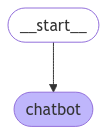

In [ ]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [ ]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I'm here to help you prepare for the Google Cloud Machine Learning exam, focusing on implementing retrieval augmented generation (RAG) applications using Vertex AI Agent Builder and Generative AI.  

To best assist you, let's start by identifying the specific areas you'd like to practice.  Which of the following topics are you most interested in reviewing through multiple-choice questions?

A.  Understanding RAG and its components (retrievers, LLMs, etc.)
B.  Designing a RAG pipeline with Vertex AI Agent Builder
C.  Connecting external knowledge bases to Agent Builder
D.  Fine-tuning LLMs for improved RAG performance
E.  Evaluating and monitoring RAG application performance
F.  Security and access control considerations for RAG applications
G. All of the above


Please select the letter(s) corresponding to the topic(s) you want to focus on.  Let's get started!



In [ ]:
user_msg = "Oh great, let's start"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I'm here to help you prepare for the Google Cloud Machine Learning exam, focusing on implementing retrieval augmented generation (RAG) applications using Vertex AI Agent Builder and Generative AI.  

To best assist you, let's start by identifying the specific areas you'd like to practice.  Which of the following topics are you most interested in reviewing through multiple-choice questions?

A.  Understanding RAG and its components (retrievers, LLMs, etc.)
B.  Designing a RAG pipeline with Vertex AI Agent Builder
C.  Connecting external knowledge bases to Agent Builder
D.  Fine-tuning LLMs for improved RAG performance
E.  Evaluating and monitoring RAG application performance
F.  Security and access control considerations for RAG applications
G. All of the above


Please select the letter(s) corresponding to the topic(s) you want to focus on.  Let's get started!

HumanMessage: Oh great, let's start
AIMessage: Okay, let's begin!  Ple

In [ ]:
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([GCPPRACTICEBOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

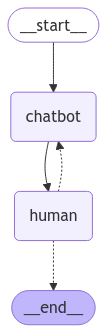

In [ ]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
               return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [ ]:
# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []})

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

#pprint(state)

Model: Welcome to the GCP ML Practice Bot. Type `q` to quit. Are you ready to practice?
User: Yes
Model: Great!  Let's start with a quick overview of the topics we can cover related to implementing retrieval augmented generation (RAG) applications using Vertex AI Agent Builder and Generative AI.  We can focus on:

1. **Vertex AI Agent Builder Fundamentals:** Understanding the core components, workflow, and capabilities of Agent Builder.
2. **Knowledge Base Creation and Management:**  Methods for preparing and structuring data for use within RAG applications.
3. **Prompt Engineering for RAG:** Crafting effective prompts to guide the agent's interaction with the knowledge base.
4. **Agent Configuration and Tuning:**  Optimizing agent behavior and performance.
5. **Integration with Generative AI Models:** Connecting Agent Builder to various generative models available on Vertex AI.
6. **Deployment and Monitoring:**  Deploying and monitoring the performance of your RAG application.


Which

In [ ]:
from langchain_core.tools import tool


@tool
def get_menu() -> str:
    """Provide the latest up-to-date topics to study."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.
    link = " A Professional Machine Learning Engineer builds, evaluates, productionizes, and optimizes AI solutions by using Google Cloud capabilities and knowledge of conventional ML approaches. The ML Engineer handles large, complex datasets and creates repeatable, reusable code. The ML Engineer designs and operationalizes generative AI solutions based on foundational models. The ML Engineer considers responsible AI practices, and collaborates closely with other job roles to ensure the long-term success of AI-based applications. The ML Engineer has strong programming skills and experience with data plaorms and distributed data processing tools. The ML Engineer is procient in the areas of model architecture, data and ML pipeline creation, generative AI, and metrics interpretation. The ML Engineer is familiar with foundational concepts of MLOps, application development, infrastructure management, data engineering, and data governance. The ML Engineer enables teams across the organization to use AI solutions. By training, retraining, deploying, scheduling, monitoring, and improving models, the ML Engineer designs and creates scalable, performant solutions. *Note: The exam does not directly assess coding skill. If you have a minimum prociency in Python and Cloud SQL, you should be able to interpret any questions with code snippets. This version of the Professional Machine Learning Engineer exam covers tasks related to generative AI, including building AI solutions using Model Garden and Vertex AI Agent Builder, and evaluating generative AI solutions. To learn more about Google Cloud’s generative AI services, go to Google Cloud Skills Boost to see the Introduction to Generative AI Learning Path (all audiences) or the Generative AI for Developers Learning Path (technical audience). If you are a partner, refer to the Gen AI partner courses: Introduction to Generative AI Learning Path, Generative AI for ML Engineers and Generative AI for Developers. For additional learning, refer to product-specic Gen AI learning oerings such as Explore and Evaluate Models using Model Garden, Vertex AI Agent Builder path (partners), Integrate Search in Applications using Vertex AI Agent Builder, and Generative Chat App with Vertex AI Agent Builder and Dialogow. Section 1: Architecting low-code AI solutions (13% of the exam) 1.1 Developing ML models by using BigQuery ML. Considerations include: ● Building the appropriate BigQuery ML model (e.g., linear and binary classication, regression, time-series, matrix factorization, boosted trees, autoencoders) based on the business problem ● Feature engineering or selection by using BigQuery ML ● Generating predictions by using BigQuery ML 1. 2 Building AI solutions by using ML APIs or foundational models. Considerations include: ● Building applications by using ML APIs from Model Garden ● Building applications by using industry-specic APIs (e.g., Document AI API, Retail API) ● Implementing retrieval augmented generation (RAG) applications by using Vertex AI Agent Builder 1.3 Training models by using AutoML. Considerations include: ● Preparing data for AutoML (e.g., feature selection, data labeling, Tabular Workows on AutoML) ● Using available data (e.g., tabular, text, speech, images, videos) to train custom models ● Using AutoML for tabular data ● Creating forecasting models by using AutoML ● Conguring and debugging trained models Section 2: Collaborating within and across teams to manage data and models (~14% of the exam) 2.1 Exploring and preprocessing organization-wide data (e.g., Cloud Storage, BigQuery, Spanner, Cloud SQL, Apache Spark, Apache Hadoop). Considerations include: ● Organizing dierent types of data (e.g., tabular, text, speech, images, videos) for ecient training ● Managing datasets in Vertex AI ● Data preprocessing (e.g., Dataow, TensorFlow Extended [TFX], BigQuery) ● Creating and consolidating features in Vertex AI Feature Store ● Privacy implications of data usage and/or collection (e.g., handling sensitive data such as personally identiable information [PII] and protected health information [PHI]) ● Ingesting dierent data sources (e.g., text documents) into Vertex AI for inference 2.2 Model prototyping using Jupyter notebooks. Considerations include: ● Choosing the appropriate Jupyter backend on Google Cloud (e.g., Vertex AI Workbench, Colab Enterprise, notebooks on Dataproc) ● Applying security best practices in Vertex AI Workbench ● Using Spark kernels ● Integrating code source repositories ● Developing models in Vertex AI Workbench by using common frameworks (e.g., TensorFlow, PyTorch, sklearn, Spark, JAX) ● Leveraging a variety of foundational and open-source models in Model Garden 2.3 Tracking and running ML experiments. Considerations include: ● Choosing the appropriate Google Cloud environment for development and experimentation (e.g., Vertex AI Experiments, Kubeow Pipelines, Vertex AI TensorBoard with TensorFlow and PyTorch) given the framework ● Evaluating generative AI solutions Section 3: Scaling prototypes into ML models (~18% of the exam) 3.1 Building models. Considerations include: ● Choosing ML framework and model architecture ● Modeling techniques given interpretability requirements 3.2 Training models. Considerations include: ● Organizing training data (e.g., tabular, text, speech, images, videos) on Google Cloud (e.g., Cloud Storage, BigQuery) ● Ingestion of various le types (e.g., CSV, JSON, images, Hadoop, databases) into training ● Training using dierent SDKs (e.g., Vertex AI custom training, Kubeow on Google Kubernetes Engine, AutoML, tabular workows) ● Using distributed training to organize reliable pipelines ● Hyperparameter tuning ● Troubleshooting ML model training failures ● Fine-tuning foundational models (e.g., Vertex AI, Model Garden) 3.3 Choosing appropriate hardware for training. Considerations include: ● Evaluation of compute and accelerator options (e.g., CPU, GPU, TPU, edge devices) ● Distributed training with TPUs and GPUs (e.g., Reduction Server on Vertex AI, Horovod) Section 4: Serving and scaling models (~20% of the exam) 4.1 Serving models. Considerations include: ● Batch and online inference (e.g., Vertex AI, Dataow, BigQuery ML, Dataproc) ● Using dierent frameworks (e.g., PyTorch, XGBoost) to serve models ● Organizing a model registry ● A/B testing dierent versions of a model 4.2 Scaling online model serving. Considerations include: ● Vertex AI Feature Store ● Vertex AI public and private endpoints ● Choosing appropriate hardware (e.g., CPU, GPU, TPU, edge) ● Scaling the serving backend based on the throughput (e.g., Vertex AI Prediction, containerized serving) ● Tuning ML models for training and serving in production (e.g., simplication techniques, optimizing the ML solution for increased performance, latency, memory, throughput) Section 5: Automating and orchestrating ML pipelines (~22% of the exam) 5.1 Developing end-to-end ML pipelines. Considerations include: ● Data and model validation ● Ensuring consistent data pre-processing between training and serving ● Hosting third-party pipelines on Google Cloud (e.g., MLFlow) ● Identifying components, parameters, triggers, and compute needs (e.g., Cloud Build, Cloud Run) ● Orchestration framework (e.g., Kubeow Pipelines, Vertex AI Pipelines, Cloud Composer) ● Hybrid or multicloud strategies ● System design with TFX components or Kubeow DSL (e.g., Dataow) 5.2 Automating model retraining. Considerations include: ● Determining an appropriate retraining policy ● Continuous integration and continuous delivery (CI/CD) model deployment (e.g., Cloud Build, Jenkins) 5.3 Tracking and auditing metadata. Considerations include: ● Tracking and comparing model artifacts and versions (e.g., Vertex AI Experiments, Vertex ML Metadata) ● Hooking into model and dataset versioning ● Model and data lineage Section 6: Monitoring AI solutions (~13% of the exam) 6.1 Identifying risks to AI solutions. Considerations include: ● Building secure AI systems by protecting against unintentional exploitation of data or models (e.g., hacking) ● Aligning with Google’s Responsible AI practices (e.g., monitoring for bias) ● Assessing AI solution readiness (e.g., fairness, bias) ● Model explainability on Vertex AI (e.g., Vertex AI Prediction) 6.2 Monitoring, testing, and troubleshooting AI solutions. Considerations include: ● Establishing continuous evaluation metrics (e.g., Vertex AI Model Monitoring, Explainable AI) ● Monitoring for training-serving skew ● Monitoring for feature aribution dri ● Monitoring model performance against baselines, simpler models, and across the time dimension ● Monitoring for common training and serving errors "
    message = "Provide a list of  Options to Practice from :"+ link
    new_output = llm.invoke([ ("user",message)])
   # print(new_output)
    return new_output

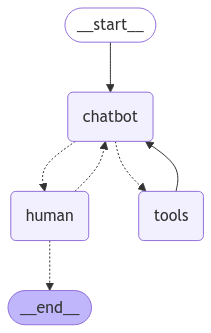

In [ ]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([GCPPRACTICEBOT_SYSINT ] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [ ]:
 state = graph_with_menu.invoke({"messages": []})

Model: Welcome to the GCP ML Practice Bot. Type `q` to quit. Are you ready to practice?
User: Y
Model: Great! What topics would you like to practice today?  I can help you with questions on Implementing retrieval augmented generation (RAG) applications by using Vertex AI Agent Builder and Generative AI.

User: 3
Model: Please specify the topics you would like to practice.  I'm ready when you are!

User: Yes
Model: Okay, let's begin!  Here's your first question:

**Question 1:** Which of the following is NOT a key component of a Retrieval Augmented Generation (RAG) application built using Vertex AI?

A)  A vector database to store embeddings of documents.
B)  A large language model (LLM) to generate text.
C)  A separate model to perform sentiment analysis on user queries.
D)  A retriever to fetch relevant documents based on user queries.


Please choose A, B, C, or D.

User: C
Model: Correct! The answer is C.

A RAG application uses an LLM to generate text based on retrieved information

In [ ]:
import gradio as gr

def greet(name):
    state = graph_with_menu.invoke({"messages": []})
    return state

demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c47b141e81d1550274.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
from gradio_agentchatbot import AgentChatbot, stream_from_transformers_agent, ChatMessage
from langchain.agents import load_tools

agent = ReactCodeAgent(tools=[image_generation_tool, search_tool], llm_engine=llm_engine)


def interact_with_agent(prompt, messages):
    messages.append(ChatMessage(role="user", content=prompt))
    yield messages
    for msg in stream_from_transformers_agent(agent, prompt):
        messages.append(msg)
        yield messages
    yield messages


with gr.Blocks() as demo:
    chatbot = AgentChatbot(label="Agent")
    text_input = gr.Textbox(lines=1, label="Chat Message")
    text_input.submit(interact_with_agent, [text_input, chatbot], [chatbot])

demo.launch()

RuntimeError: Failed to import transformers.agents.agents because of the following error (look up to see its traceback):
Failed to import transformers.models.auto.processing_auto because of the following error (look up to see its traceback):
'NoneType' object has no attribute 'Rlocation'